# **Solving the Gym Bowling Environnement using an Actor-Critic agent**

Adam Aboucaya and Remi Vialleton made this notebook for the Reinforcement Learning course at the University of Stavanger during the first semester of 2024-2025. 

## **Introduction**

The **Atari Bowling Environnement** is an emulation of the Atari Bowling game where the player tries to roll a score as high as possible using a joystick. There are 10 "pins" on the lane and the player is controlling the bowler on the screen and tries to knock as much "pins" as possible. A game consists of 10 "frames".
Knocking down all the pins on the first try is called a **strike** and on the second try is called a **spare**. The maximum score one can make is 300 by scoring only strikes.

In this notebook, we are trying to score the best score as possible in the Atari Bowling Environnement using an **Actor-Critic agent**. We will first **analyze the environnement**, then **explain and implement our approach** and finally **evaluate the model and discuss the results**.

## **Setup and imports**

You may as well want to make sure that you have a `.pth` model file under the `saved_models` folder to be able to lauch the test cell, otherwise you'll have to train the model again.

### **Installing Libraries**

In [206]:
# Uncomment these lines if you need to install the required libraries

# %pip install gymnasium ale-py
# %pip install gymnasium[atari]
# %pip install gymnasium[accept-rom-license]
# %pip install torch
# %pip install matplotlib
# %pip install numpy

### **Importing Libraries**

In [207]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import ale_py
from collections import deque
import matplotlib.pyplot as plt
import random
from torch.optim.lr_scheduler import StepLR
import os

### **Setting up environnement and random seeds**

In [208]:
ENV_NAME = 'ALE/Bowling-v5'
RANDOM_STATE = 10
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

## **Environment Exploration**

We will here take a deeper look into the specifications of the environnement. To implement our models, we need to know how a state is represented as well as how does an action look like.

Let's take a look at how the images look like:

In [ ]:
env.reset()
obs = env.render()
plt.imshow(obs)

In [209]:
env = gym.make(ENV_NAME, render_mode='rgb_array')

state, _ = env.reset()
print(f"Initial state: \n{state}")
print(f"Observation space: \n{env.observation_space}")
print(f"Action space: {env.action_space}")

a = env.action_space.sample()
event = env.step(a)
print('Output from applying action {} on environment:\nstate:'.format(a) \
      + '{}\nreward: {}\ndone: {}\ntruncated: {}\ninfo: {}'.format(*event))

Initial state: 
[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 ...

 [[180 122  48]
  [180 122  48]
  [180 122  48]
  ...
  [180 122  48]
  [180 122  48]
  [180 122  48]]

 [[180 122  48]
  [180 122  48]
  [180 122  48]
  ...
  [180 122  48]
  [180 122  48]
  [180 122  48]]

 [[180 122  48]
  [180 122  48]
  [180 122  48]
  ...
  [180 122  48]
  [180 122  48]
  [180 122  48]]]
Observation space: 
Box(0, 255, (210, 160, 3), uint8)
Action space: Discrete(6)
Output from applying action 4 on environment:
state:[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0

We can see the different values returned by the `env.step()` method as well as the shape of both the action space and the state space. We can then identify a state space of shape **(210, 160, 3)** with values from 0 to 255. So the image is 210 pixels high, 160 pixels large and the third dimension stands for the rgb colors.

As for the action space, it is represented by 6 discrete actions listed in the table below (refering to the [ALE Documentation](https://ale.farama.org/environments/bowling/)).

| **Action** | **Meaning**                                |
|------------|--------------------------------------------|
| 0          | NOOP                                       |
| 1          | FIRE                                       |
| 2          | UP                                         |
| 3          | DOWN                                       |
| 4          | UPFIRE                                     |
| 5          | DOWNFIRE                                   |

By rendering the episodes during training, we found that **rewards were given at the end of each "frame"** (2 throws) and that it corresponded to the number of pins putted down during the frame.

## **Overview of the Actor-Critic Model**

The Actor-Critic (A2C) model is a type of reinforcement learning algorithm that combines the benefits of both value-based and policy-based methods. It consists of two main components: the *Actor* and the *Critic*. 

- *The Actor* selects actions based on the current policy.
- *The Critic* evaluates these actions by estimating the value function.

---

### *1. Actor*

The Actor is a neural network that takes the current state as input and outputs a probability distribution over possible actions. The Actor's goal is to learn a policy that maximizes the expected cumulative reward. The policy is updated using the policy gradient method, which adjusts the parameters of the Actor in the direction that increases the probability of actions that lead to higher rewards.

---

### *2. Critic*

The Critic is another neural network that takes the current state as input and outputs a scalar value representing the estimated value of that state. The Critic's goal is to learn the value function, which is used to evaluate the actions taken by the Actor. The value function is updated using the temporal difference (TD) error, which measures the difference between the predicted value and the actual reward received.

---

### *3. Mathematical Principles*

#### *Policy Gradient*

The policy gradient method is used to update the parameters of the Actor. The objective is to maximize the expected cumulative reward, which can be expressed as:

$$
J(\theta) = \mathbb{E}_{\pi_\theta} \left[ \sum_{t=0}^{T} \gamma^t R_t \right]
$$

where:

- $ \theta $ are the parameters of the Actor.
- $ \pi_\theta $ is the policy parameterized by $ \theta $.
- $ R_t $ is the reward at time step $ t $.
- $ \gamma $ is the discount factor.

---

#### *Advantage Function*

The advantage function is defined as:

$$
A_t = Q(s_t, a_t) - V(s_t)
$$

where:

- $ Q(s_t, a_t) $ is the action-value function, which estimates the value of taking action $ a_t $ in state $ s_t $.
- $ V(s_t) $ is the value function, which estimates the value of state $ s_t $.

In practice, the advantage function can be approximated using the TD error:

$$
A_t \approx R_t + \gamma V(s_{t+1}) - V(s_t)
$$

---

#### *Temporal Difference (TD) Error and Loss Minimization*

The TD error is used to update the parameters of the Critic. It measures the difference between the predicted value of a state and the observed return, helping the Critic network to improve its accuracy. The TD error is given by:

$$
\delta_t = R_t + \gamma V(s_{t+1}) - V(s_t)
$$

To minimize this error, the Critic network parameters (denoted by $ \phi $) are updated by minimizing the *mean squared error* (MSE) of the TD error. The Critic’s loss function, which represents this error minimization, is defined as:

$$
L(\phi) = \mathbb{E} \left[ \delta_t^2 \right]
$$

where $ \phi $ are the parameters of the Critic. By minimizing this loss function, the Critic learns a more accurate value function $ V(s) $, which in turn improves the calculation of the advantage function $ A_t $.

#### *Link Between Loss Minimization and Actor Update*

The improved value function from the Critic’s training helps refine the Actor's policy. The Actor relies on the *advantage function* $ A_t $ (which uses the Critic's value estimates) to determine the direction in which to update its policy parameters $ \theta $. By optimizing the Critic's loss, we get more reliable advantage estimates, enabling the Actor to make better-informed policy updates. Here is the Actor's loss function:

$$
L(\theta) = -\mathbb{E} \left[ \log{\pi(a | \theta)} \times A_t\right]
$$

Thus, minimizing the Critic's loss function indirectly supports the Actor's policy improvement, as the Actor’s updates use the Critic's value estimates to gauge the quality of actions. This interdependency between the Actor and Critic is central to the Actor-Critic model's success in reinforcement learning.

## **Model Architecture**

### 1. Critic Architecture

The *Critic* takes the current state as input and produces a scalar estimate of the value of that state. This value estimation is used to evaluate the quality of the actions taken by the Actor.

- *Input Layer*: Accepts a vector of size state_size, representing the current state.
- *Fully Connected Layer 1*: A linear layer with 256 units followed by ReLU activation.
- *Fully Connected Layer 2*: A linear layer with 128 units followed by ReLU activation.
- *Fully Connected Layer 3*: A linear layer with 64 units followed by ReLU activation.
- *Output Layer*: A linear layer with 1 unit (no activation) that outputs a scalar estimate of the state's value.

---

### 2. Actor Architecture

The *Actor* also takes the current state as input but outputs a probability distribution over the possible actions. This distribution represents the likelihood of each action, enabling the agent to sample actions according to its policy.

- *Input Layer*: Accepts a vector of size state_size, representing the current state.
- *Fully Connected Layer 1*: A linear layer with 256 units followed by ReLU activation.
- *Fully Connected Layer 2*: A linear layer with 128 units followed by ReLU activation.
- *Fully Connected Layer 3*: A linear layer with 64 units followed by ReLU activation.
- *Output Layer*: A linear layer with action_size units (number of possible actions), followed by a softmax activation to produce a probability distribution over actions.

Additionally, the output is clamped to keep the values within a specific range before applying softmax, helping to maintain stable probabilities.

---

Moreover, we attempted to implement CNNs instead of linear models, as we used an environment version where the input represents the game image. However, the computational cost was too high, resulting in significantly longer training times with similar or even worse results.

## **Implementation of the models**

In [213]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()

        # Defining the layers
        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, action_size)

    def forward(self, x):
        # Forward pass adding a ReLU activation
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.clamp(x, -10, 10) # Clamp the output between -10 and 10 to prevent the actor to predict too low values and cause errors in the log function
        return torch.softmax(self.fc4(x), dim=-1)

In [214]:
class Critic(nn.Module):
    def __init__(self, state_size):
        super(Critic, self).__init__()
        # Defining the layers

        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        # Forward pass adding a ReLU activation
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)


## **Training Method**

The training of the A2C (Advantage Actor-Critic) agent involves several key components such as exploration-exploitation balance, updating the agent's parameters, and learning rate scheduling. In this section, we’ll dive into the detailed methodology used for training our A2C agent, explaining the role of exploration (epsilon-greedy strategy), learning rate, scheduler, parameter updates, and how frequently each component is adjusted.

### 1. *Exploration vs Exploitation: Epsilon-Greedy Strategy*
   - *Epsilon-Greedy Strategy:* 
     - During training, the agent needs to balance between *exploration* (trying new actions) and *exploitation* (choosing actions based on past experience). To manage this, the epsilon-greedy strategy is employed.
     - The agent starts with a relatively high epsilon value (initially set to 0.35), meaning it will explore new actions randomly with this probability, allowing it to gather more diverse experiences. As the training progresses, epsilon gradually decreases (by multiplying it by epsilon_decay = 0.97 after every step), reducing the randomness in the agent’s actions and increasing the exploitation of learned strategies.
     - *Minimum Epsilon:* Exploration is gradually reduced, but epsilon never goes below a certain threshold (epsilon_min = 0.01), ensuring that the agent retains a minimal level of exploration throughout its training.

### 2. *Learning Rate and Scheduler*
   - *Learning Rate:*
     - The learning rate determines the size of the steps taken in the direction of the gradient during the optimization process. A learning rate of 0.0001 is used for both the *actor* and *critic* networks.
   
   - *Learning Rate Schedulers:*
     - To improve convergence and avoid overshooting optimal solutions, *learning rate schedulers* are implemented for both the actor and critic optimizers. Specifically, the *StepLR* scheduler is used.
     - The learning rate is decayed after a fixed number of steps (step_size = 50), reducing the learning rate by a factor of gamma = 0.9. This helps the agent to make finer adjustments as it gets closer to the optimal policy.
     - The schedulers are updated *after each training epoch* (self.actor_scheduler.step() and self.critic_scheduler.step()).

### 3. *Parameter Updates: How and When Are Parameters Updated?*
   - *Gradient Descent with Actor-Critic Loss:*
     - The agent is trained using the *Advantage Actor-Critic (A2C)* algorithm, where both the actor (policy) and critic (value function) networks are updated.
     - *Critic Update:* 
       - The critic is updated to minimize the *mean squared error (MSE)* between the predicted value (values) and the target value, which is the reward plus the discounted value of the next state (rewards + gamma * next_values * (1 - dones)).
     - *Actor Update:*
       - The actor is updated using the *policy gradient method*. Specifically, the *actor loss* is calculated as the negative log probability of the chosen actions weighted by the advantages (log_probs * advantages.detach()).
     - The loss functions for both the actor and critic are computed, and the gradients are calculated using *backpropagation*. 
     - Both the *actor* and *critic* networks' parameters are updated through the step() function of their respective optimizers after the gradients are computed.

   - *Frequency of Parameter Updates:*
     - Parameter updates occur *after every batch* of transitions is collected. The transitions are stored in a *replay buffer* of size 1000 and sampled randomly in batches (of size batch_size = 128) for training.
     - *When is a batch sampled for training?*
       - The buffer must contain at least 128 transitions (equal to the batch size) before a batch can be sampled and training can occur. If the buffer has fewer than 128 transitions, no updates will be performed, and the agent will continue collecting more transitions until the buffer reaches the required size.
     - *Batch Updates:* 
       - When the buffer has enough transitions (>= batch_size = 128), a random batch is sampled and the model parameters (actor and critic) are updated in the following way:
         - The *critic's loss* is computed using the current state and the next state value predictions.
         - The *actor's loss* is calculated based on the advantages derived from the critic's value estimates.
         - The *actor* and *critic* networks are updated through backpropagation using the computed gradients.
   
### 4. *Training Process Overview*
   - *Epochs and Episodes:*
     - Training occurs over a number of *epochs* (the total number of training iterations), and within each epoch, the agent plays multiple *episodes* in the environment.
     - For each episode, the agent selects actions according to its current policy, receives rewards, and stores the experiences (state, action, reward, next state, done) in the replay buffer.
     - The agent then samples a batch from this buffer to update its policy (actor) and value function (critic).

   - *Early Stopping Condition:*
     - The training loop monitors the *mean score* over the last 10 episodes. If the mean score exceeds a threshold (e.g., mean_score >= 75), the model is saved, and training stops early.
     - This helps prevent overfitting and ensures the agent is performing well before continuing with further training.

### Summary of Key Parameters and Their Roles:
- **Gamma**: Discount factor for future rewards, used in both actor and critic to prioritize immediate vs future rewards.
- **Epsilon**: Controls the exploration-exploitation tradeoff.
- **Learning Rate**: Dictates the size of the steps during optimization.
- **Batch Size**: Number of transitions sampled for each training step.
- **Replay Buffer Size**: Number of transitions stored for sampling and training.

By combining exploration (epsilon-greedy strategy), gradual learning rate decay (using the scheduler), and a stable training process with the A2C algorithm, this agent efficiently learns a policy to solve the environment.


## **Defining Variables**

In [215]:
GAMMA = 0.97

EPOCHS = 200
BATCH_SIZE = 128
MAX_MOVES = 5000
REPLAY_BUFFER_SIZE = 1000

EPSILON = 0.45
EPSILON_DECAY = 0.96
EPSILON_MIN = 0.01

AVERAGE_SCORE_WINDOW_SIZE = 10
AVERAGE_SCORE_OBJECTIVE = 75
SAVED_MODELS_DIR = './saved_models'

NUM_TESTS = 10

## **Implementing the Agent**

In [216]:
class A2CAgent:
    def __init__(self, env):
        # Environment
        self.env = env
        self.env.seed = torch.seed
        self.state_size = np.prod(env.observation_space.shape)
        self.action_size = env.action_space.n

        # Device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Actor and critic
        self.actor = Actor(self.state_size, self.action_size).to(self.device)
        self.critic = Critic(self.state_size).to(self.device)

        # Optimizers
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=0.0001)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=0.0001)

        # Learning rate schedulers
        self.actor_scheduler = StepLR(self.actor_optimizer, step_size=50, gamma=0.9)
        self.critic_scheduler = StepLR(self.critic_optimizer, step_size=50, gamma=0.9)

        # Exploration and other parameters
        self.gamma = GAMMA
        self.epsilon = EPSILON
        self.epsilon_decay = EPSILON_DECAY
        self.epsilon_min = EPSILON_MIN

        # Sliding window for calculating the average score
        self.scores_window = deque(maxlen=AVERAGE_SCORE_WINDOW_SIZE)
        
        # Directory for saving models
        self.save_dir = SAVED_MODELS_DIR
        os.makedirs(self.save_dir, exist_ok=True)

    def save_model(self, epoch, mean_score):
        """Saves both the actor and critic models to the specified directory."""

        model_path = os.path.join(self.save_dir, f"actor_critic_epoch_{epoch}_mean_score_{mean_score:.2f}.pth")
        print(f"Saving model to {model_path}")
        torch.save({
            'actor_state_dict': self.actor.state_dict(),
            'critic_state_dict': self.critic.state_dict(),
            'actor_optimizer_state_dict': self.actor_optimizer.state_dict(),
            'critic_optimizer_state_dict': self.critic_optimizer.state_dict(),
            'epoch': epoch,
            'mean_score': mean_score
        }, model_path)
        
    def load_model(self, model_path):
        """Loads the weights of the actor and critic models from the specified file."""

        map_location = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        checkpoint = torch.load(model_path, map_location=map_location)
        self.actor.load_state_dict(checkpoint['actor_state_dict'])
        self.critic.load_state_dict(checkpoint['critic_state_dict'])
        self.actor_optimizer.load_state_dict(checkpoint['actor_optimizer_state_dict'])
        self.critic_optimizer.load_state_dict(checkpoint['critic_optimizer_state_dict'])
        print(f"Model loaded from {model_path}")

    def get_action(self, state):
        """Gets the action to take based on epsilon-greedy strategy."""
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)  # Random action for exploration
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        probs = self.actor(state).detach().cpu().numpy()[0] # Getting policy
        action = np.random.choice(self.action_size, p=probs) # Choosing the action depending on policy

        return action

    def train(self, epochs=EPOCHS, max_moves=MAX_MOVES, batch_size=BATCH_SIZE):
        """Training loop for the agent."""
        try:
            # Initializing stats variables
            scores = []
            info = {
                "epochs": [],
                "scores": [],
                "actor_loss": [],
                "critic_loss": []
            }

            buffer = deque(maxlen=REPLAY_BUFFER_SIZE)  # Buffer for storing transitions
            for e in range(epochs):
                # Refreshing the environnement
                state, _ = self.env.reset()
                state = state.flatten()
                done = False
                score = 0
                max_moves_remaining = max_moves

                # Loop until the episode finishes or max moves are reached
                while not done and max_moves_remaining > 0:

                    max_moves_remaining -= 1
                    action = self.get_action(state) # Choosing an action
                    next_state, reward, done, truncated, _ = self.env.step(action) # Interacting with the environment
                    next_state = next_state.flatten()

                    # Store the experience in the buffer
                    buffer.append((state, action, reward, next_state, done))

                    state = next_state
                    score += reward

                # Update by batch
                if len(buffer) >= batch_size:
                    transitions = random.sample(buffer, batch_size) # Selecting random samples

                    # Extracting transitions
                    states, actions, rewards, next_states, dones = zip(*transitions)
                    states_tensor = torch.from_numpy(np.array(states)).float().to(self.device)
                    next_states_tensor = torch.from_numpy(np.array(next_states)).float().to(self.device)
                    actions_tensor = torch.tensor(actions, dtype=torch.long).to(self.device)
                    rewards_tensor = torch.tensor(rewards, dtype=torch.float32).to(self.device)
                    dones_tensor = torch.tensor(dones, dtype=torch.float32).to(self.device)

                    # Calculate values and advantages
                    values = self.critic(states_tensor).to(self.device)
                    next_values = self.critic(next_states_tensor).detach().to(self.device)
                    advantages = rewards_tensor + self.gamma * next_values * (1 - dones_tensor) - values

                    # Calculate actor loss
                    probs = self.actor(states_tensor)
                    log_probs = torch.log(probs[range(batch_size), actions_tensor])
                    actor_loss = -(log_probs * advantages.detach()).mean()

                    # Calculate critic loss
                    critic_loss = (advantages.pow(2)).mean()

                    # Update actor and critic with gradient
                    self.actor_optimizer.zero_grad()
                    actor_loss.backward()
                    self.actor_optimizer.step()

                    self.critic_optimizer.zero_grad()
                    critic_loss.backward()
                    self.critic_optimizer.step()

                # Decay epsilon to reduce exploration
                if self.epsilon > self.epsilon_min:
                    self.epsilon *= self.epsilon_decay

                # Add score to the sliding window and calculate the mean
                self.scores_window.append(score)
                mean_score = np.mean(self.scores_window)

                # Update stats
                scores.append(score)
                info["epochs"].append(e)
                info["scores"].append(scores[e])
                info["actor_loss"].append(actor_loss.item())
                info["critic_loss"].append(critic_loss.item())

                print(f'Epoch: {e+1}/{epochs}, Score: {score}, Mean Score (Last {AVERAGE_SCORE_WINDOW_SIZE}): {mean_score:.2f}, Actor Loss: {actor_loss.item()}, Critic Loss: {critic_loss.item()}')

                # Check if the stopping condition is met and save the model if it's the case
                if mean_score >= AVERAGE_SCORE_OBJECTIVE:
                    self.save_model(e, mean_score)
                    break

                # Step the schedulers to update the learning rate
                self.actor_scheduler.step()
                self.critic_scheduler.step()
        
        except KeyboardInterrupt:
            print("Training interrupted by user.")
            pass

        return info

    def test(self, episodes=NUM_TESTS, max_moves=MAX_MOVES, render=True):
        """Testing loop for the agent."""

        for e in range(episodes):
            state, _ = self.env.reset()
            state = state.flatten()
            done = False
            score = 0
            max_moves_remaining = max_moves
            while not done and max_moves_remaining > 0:
                if render:
                    self.env.render()
                max_moves_remaining -= 1
                action = self.get_action(state)
                next_state, reward, done, truncated, _ = self.env.step(action)
                next_state = next_state.flatten()
                score += reward
                state = next_state
            print(f'Test Episode: {e+1}/{episodes}, Score: {score}')


    def plot(self, info_):
        """Plots the results of the training."""

        epochs, scores, actor_loss, critic_loss = info_["epochs"], info_["scores"], info_["actor_loss"], info_["critic_loss"]

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

        ax1.plot(epochs, scores)
        ax1.set_title('Scores')
        ax1.set_xlabel('episode')
        ax1.set_ylabel('score')

        ax2.plot(epochs, actor_loss)
        ax2.set_title('Actor Loss')
        ax2.set_xlabel('episode')
        ax2.set_ylabel('loss')

        ax3.plot(epochs, critic_loss)
        ax3.set_title('Critic Loss')
        ax3.set_xlabel('episode')
        ax3.set_ylabel('loss')

        plt.show()

Epoch: 1/200, Score: 36.0, Mean Score (Last 10): 36.00, Actor Loss: 0.20397469401359558, Critic Loss: 0.03159672021865845
Epoch: 2/200, Score: 36.0, Mean Score (Last 10): 36.00, Actor Loss: -7.962862968444824, Critic Loss: 7.636726379394531
Epoch: 3/200, Score: 51.0, Mean Score (Last 10): 41.00, Actor Loss: 5.006895542144775, Critic Loss: 58.14878845214844
Epoch: 4/200, Score: 60.0, Mean Score (Last 10): 45.75, Actor Loss: 0.5021952390670776, Critic Loss: 0.032719459384679794
Epoch: 5/200, Score: 41.0, Mean Score (Last 10): 44.80, Actor Loss: -3.1811435222625732, Critic Loss: 0.824403703212738
Epoch: 6/200, Score: 54.0, Mean Score (Last 10): 46.33, Actor Loss: -3.345782518386841, Critic Loss: 1.3062351942062378
Epoch: 7/200, Score: 51.0, Mean Score (Last 10): 47.00, Actor Loss: -1.3840687274932861, Critic Loss: 0.2778151035308838
Epoch: 8/200, Score: 66.0, Mean Score (Last 10): 49.38, Actor Loss: 0.8352001309394836, Critic Loss: 0.27271145582199097
Epoch: 9/200, Score: 41.0, Mean Score

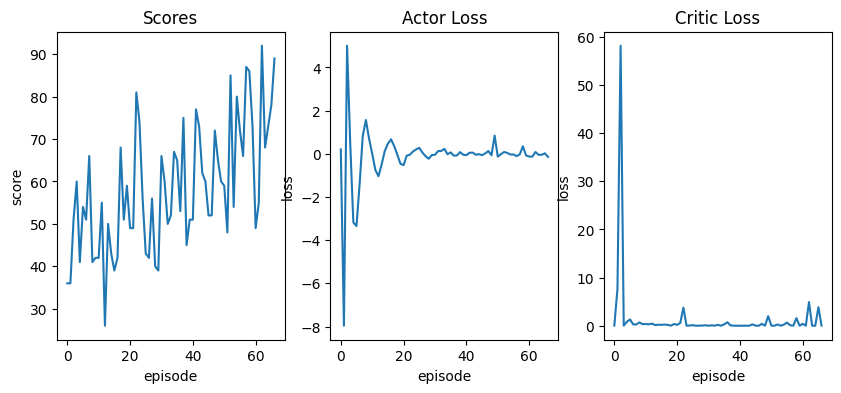

In [ ]:
env = gym.make(ENV_NAME)
agent = A2CAgent(env)
info = agent.train(epochs=EPOCHS)
agent.plot(info)

## **Evaluation**

In [ ]:
# Loading the trained model
model_path = "./saved_models/actor_critic_epoch_75_mean_score_75.60.pth" 
agent.load_model(model_path)

print("Testing the agent...")
agent.env = gym.make(ENV_NAME, render_mode="human")
agent.test(episodes=NUM_TESTS, render=True)

C:\Users\rem3D\AppData\Local\Temp\ipykernel_15976\3804447197.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=map_locati

Model loaded from ./saved_models/actor_critic_epoch_75_mean_score_75.60.pth
Testing the agent...
Test Episode: 1/10, Score: 89.0
Test Episode: 2/10, Score: 104.0


## **Conclusion**

To conclude, the results obtained are pretty good even if there is room for optimization. Our approach allows for fast learning but its randomness leads to uncertain results each time the model is trained. It gives good results with finetuning the hyperparameters but we still had to train multiple times for the model to give the best results. The main optimization we could make would be to stabilize the results and get a more reproducible training process.
We tried many other approaches like DA2C, PPO or the ICM Module but we struggled to fine tune the hyperparameters and the computational cost and training time was not managable.

Handling sparse reward environnement is a difficult task in reinforcement learning and we learned a lot trying to find the best method to increase exploration in our model.